Function to search images on DuckDuckGo, and do a test search and display it. 

In [1]:
# Workaround for training output not visible in JupyterNotebook https://github.com/microsoft/vscode-jupyter/issues/13163
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG'

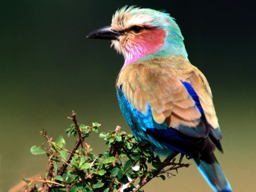

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


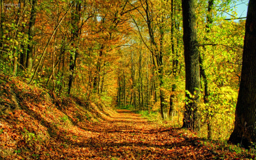

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Search DuckDuckGo for forest photos and bird photos with sun and shade variants, download to `bird_or_not/`.

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


Some downloaded images will be corrupt, remove them.

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

Create a `DataBlock` which will be used for training.  
`blocks=(ImageBlock, CategoryBlock),` : The input is of type image, the output is of type category.  
`get_items=get_image_files,`: Get all the images from `path` defined below, which is `bird_or_not`.  
`splitter=RandomSplitter(valid_pct=0.2, seed=42),`: Randomly pick 20% of the images as validation.  
`get_y=parent_label,`:  Use the parent folder name (bird, forest) as the label for the item.  
`item_tfms=[Resize(192, method='squish')]`: Transform each item, resize to 192px.  

Display a few of the items. 

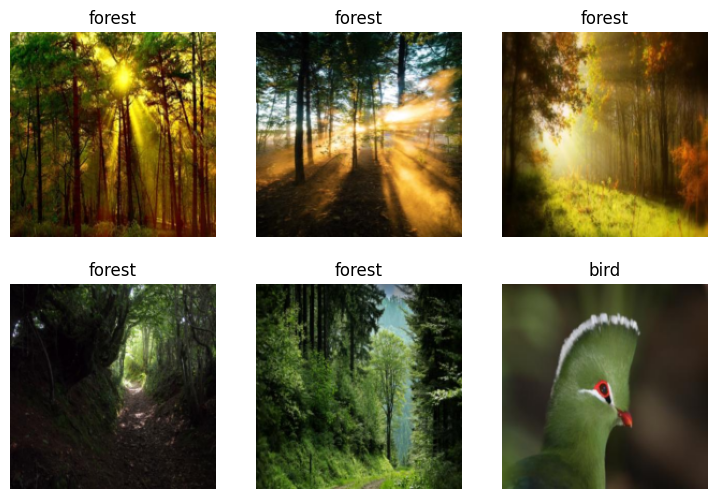

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Use the above `DataBlock` for vision learning. Use the `resnet18` model. 

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.016528,0.000798,0.000000,00:03
1,0.007879,0.000032,0.000000,00:03
2,0.006533,0.000048,0.000000,00:03


Pass the previously downloaded bird.jpg and forest.jpg to the learner to identify whether it's a bird or not, with probability value. 

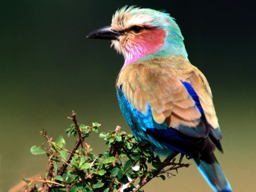

In [10]:

im = Image.open('bird.jpg')
im.to_thumb(256,256)


In [11]:

is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability it is a bird: {probs[0]:.4f}")


This is a: bird
Probability it is a bird: 1.0000


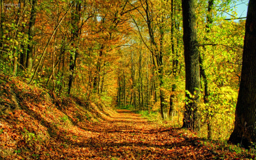

In [12]:
im = Image.open('forest.jpg')
im.to_thumb(256,256)

In [13]:
is_bird, _, probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability it is a bird: {probs[0]:.4f}")

This is a: forest
Probability it is a bird: 0.0000


Searching for 'kingfisher'


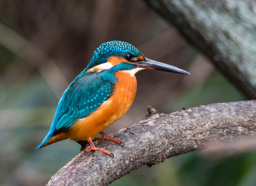

In [14]:
download_url(search_images('kingfisher', max_images=1)[0], 'kingfisher.jpg', show_progress=False)
Image.open('kingfisher.jpg').to_thumb(256,256)

In [15]:
is_bird, _, probs = learn.predict(PILImage.create('kingfisher.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability it is a bird: {probs[0]:.4f}")

This is a: bird
Probability it is a bird: 1.0000


Searching for 'eagle'


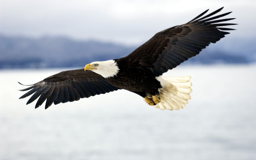

In [16]:
download_url(search_images('eagle', max_images=1)[0], 'eagle.jpg', show_progress=False)
Image.open('eagle.jpg').to_thumb(256,256)

In [17]:
is_bird, _, probs = learn.predict(PILImage.create('eagle.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability it is a bird: {probs[0]:.4f}")

This is a: bird
Probability it is a bird: 1.0000


Searching for 'butterfly'


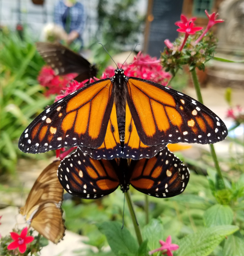

In [18]:
download_url(search_images('butterfly', max_images=1)[0], 'butterfly.jpg', show_progress=False)
Image.open('butterfly.jpg').to_thumb(256,256)

In [19]:
is_bird, _, probs = learn.predict(PILImage.create('butterfly.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability it is a bird: {probs[0]:.4f}")

This is a: bird
Probability it is a bird: 0.9999


Searching for 'plane'


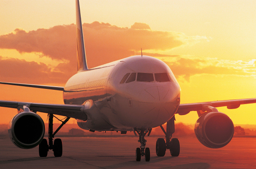

In [23]:
download_url(search_images('plane', max_images=1)[0], 'plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256,256)

In [24]:
is_bird, _, probs = learn.predict(PILImage.create('plane.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability it is a bird: {probs[0]:.4f}")

This is a: bird
Probability it is a bird: 1.0000
